### Import Required Packages and Set Options

#### Import Base Libraries

In [2]:
import os
import sys
#import git
import random

import numpy as np
#import numba as nb
import pandas as pd
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.3f}'.format)

sns.set_style('whitegrid')
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# plt.rcParams

#### Put the Main Package Library on the PYTHONPATH

In [4]:
# git_repo = git.Repo('.', search_parent_directories=True)
# git_root = git_repo.git.rev_parse('--show-toplevel')
# cython_path = os.path.join(git_root, 'rankfm')

# sys.path[0] = git_root
# sys.path[1] = cython_path
# sys.path[:2]

#### Re-Compile Cython Extension Module

In [5]:
# !cd $git_root && python setup.py build_ext --inplace

#### Dynamically Re-Load all Package Modules on Execution

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
from rankfm.rankfm import RankFM
from rankfm.evaluation import hit_rate, reciprocal_rank, discounted_cumulative_gain, precision, recall, diversity

#### Set File Path Constants

In [8]:
data_path = os.path.join(git_root, "data/instacart_2017_05_01")
print("\n".join([git_root, data_path]))

NameError: name 'git_root' is not defined

In [9]:
!pwd

/home/erlebach/src/2022/rankfm/data/copa_recommender/one_destination_per_member


In [10]:
data_path = "." # os.path.join(git_root, "data/instacart_2017_05_01")
# print("\n".join([git_root, data_path]))

### Prepare Copa Data
* this data comes from https://www.instacart.com/datasets/grocery-shopping-2017
* Instacart open-sourced an anonymized version of their grocery store shopping data for research/kaggle purposes

#### Load Departments Data

In [11]:
years = ['2016', '2017']
df = {}
files = {}
for year in years:
    files[year] = f"members_{year}.csv"
    df[year] = pd.read_csv(files[year])

In [12]:
for year in years:
    df[year] = df[year][['userID', 'itemID']]
    df[year].columns = ['user_id', 'product_id']
    df[year]['year'] = year

In [13]:
df[2016].shape, df[2017].shape

KeyError: 2016

In [14]:
# departments_df = pd.read_csv(os.path.join(data_path, 'departments.csv'))
# departments_df['department_id'] = departments_df['department_id'].astype(np.uint8)
# departments_df.info(show_counts=False)
# # departments_df.describe()
# departments_df.head()

#### Load Destination Data

#### Create a User/Item Interaction Data Set

In [15]:
df_g = {}
for year in years:
    df_g[year] = df[year].groupby(['user_id', 'product_id'])

In [16]:
interactions = pd.concat([df[year] for year in years], axis=0)

#### Check that there is only one entry per member_id/destination/year group  

In [17]:
interactions.groupby(['user_id','product_id','year']).size().max()

1

In [18]:
# orders_cols = ['order_id', 'user_id']
# order_products_cols = ['order_id', 'product_id']
# interaction_cols = ['user_id', 'product_id', 'order_id']

# interactions = pd.merge(orders_df[orders_cols], order_products_df[order_products_cols], on='order_id', how='inner')
# interactions = interactions[interaction_cols]

# interactions.info()
# interactions.head()

#### Create an Item Features Data Set

In [19]:
item_features = pd.get_dummies(products_df[['product_id', 'aisle_id']], columns=['aisle_id'])
item_features.head()

NameError: name 'products_df' is not defined

### Do Some Basic EDA

#### Cardinality

In [42]:
n_departments = departments_df.department_id.nunique()
n_aisles = aisles_df.aisle_id.nunique()

n_users = interactions.user_id.nunique()
n_items = interactions.product_id.nunique()
n_orders = interactions.order_id.nunique()
n_interactions = len(interactions)

In [43]:
template = "departments: {}\naisles: {}\nusers: {}\nitems: {}\norders: {}\ninteractions: {}"
print(template.format(n_departments, n_aisles, n_users, n_items, n_orders, n_interactions))

departments: 21
aisles: 134
users: 206209
items: 49677
orders: 3214874
interactions: 32434489


#### Key User/Item Distributions

In [72]:
# number of items/orders by user
cnt_item_user = interactions.groupby('user_id')['product_id'].nunique()
cnt_order_user = interactions.groupby('user_id')['order_id'].nunique()

# number of users/orders by item
cnt_user_item = interactions.groupby('product_id')['user_id'].nunique()
cnt_order_item = interactions.groupby('product_id')['order_id'].nunique()

In [74]:
cnt_item_user.describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])

count   206209.000
mean        64.536
std         56.592
min          1.000
5%           8.000
10%         13.000
25%         25.000
50%         48.000
75%         86.000
90%        139.000
95%        179.000
max        726.000
Name: product_id, dtype: float64

In [75]:
cnt_order_user.describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])

count   206209.000
mean        15.590
std         16.655
min          3.000
5%           3.000
10%          3.000
25%          5.000
50%          9.000
75%         19.000
90%         37.000
95%         51.000
max         99.000
Name: order_id, dtype: float64

In [76]:
cnt_user_item.describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])

count   49677.000
mean      267.890
std      1308.789
min         1.000
5%          4.000
10%         5.000
25%        11.000
50%        35.000
75%       137.000
90%       491.000
95%      1026.200
max     73956.000
Name: user_id, dtype: float64

In [77]:
cnt_order_item.describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])

count    49677.000
mean       652.908
std       4792.114
min          1.000
5%           5.000
10%          7.000
25%         17.000
50%         60.000
75%        260.000
90%       1021.000
95%       2286.000
max     472565.000
Name: order_id, dtype: float64

/home/erlebach/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


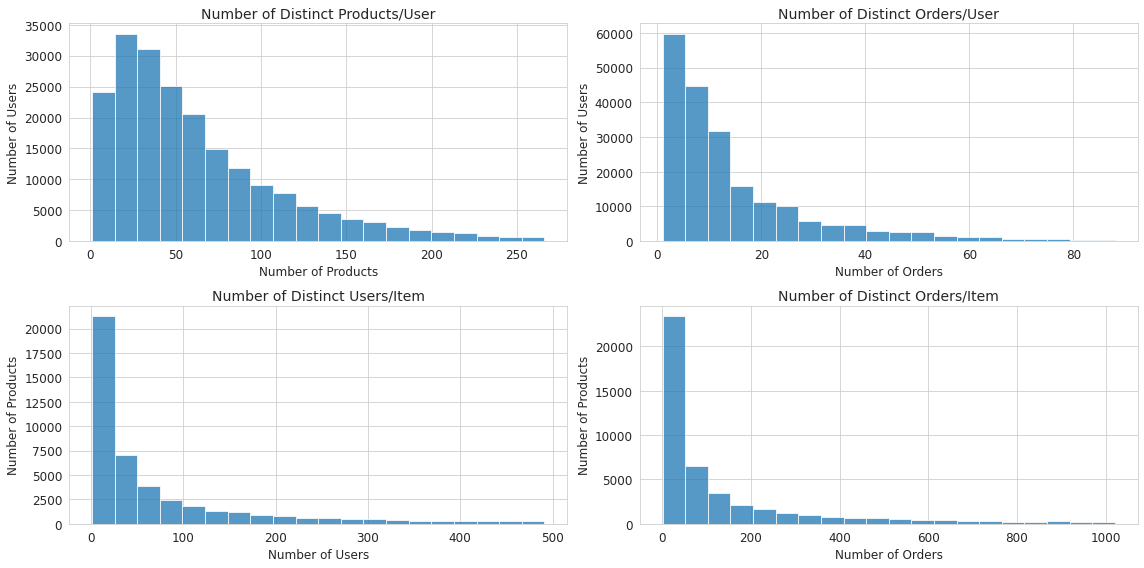

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes = axes.flatten()

range_0 = [1, cnt_item_user.quantile(0.99)]
range_1 = [1, cnt_order_user.quantile(0.99)]
range_2 = [1, cnt_user_item.quantile(0.90)]
range_3 = [1, cnt_order_item.quantile(0.90)]

sns_dist_params = dict(bins=20, hist=True, kde=False, rug=False)
sns.distplot(cnt_item_user,  **sns_dist_params, hist_kws={'range': range_0, 'alpha': 0.75}, ax=axes[0])
sns.distplot(cnt_order_user, **sns_dist_params, hist_kws={'range': range_1, 'alpha': 0.75}, ax=axes[1])
sns.distplot(cnt_user_item,  **sns_dist_params, hist_kws={'range': range_2, 'alpha': 0.75}, ax=axes[2])
sns.distplot(cnt_order_item, **sns_dist_params, hist_kws={'range': range_3, 'alpha': 0.75}, ax=axes[3])

axes[0].set(title="Number of Distinct Products/User", xlabel='Number of Products', ylabel='Number of Users')
axes[1].set(title="Number of Distinct Orders/User", xlabel='Number of Orders', ylabel='Number of Users')
axes[2].set(title="Number of Distinct Users/Item", xlabel='Number of Users', ylabel='Number of Products')
axes[3].set(title="Number of Distinct Orders/Item", xlabel='Number of Orders', ylabel='Number of Products')

fig.tight_layout()
plt.show()

#### User/Item Re-Purchases

In [81]:
user_item_orders = interactions.groupby(['user_id', 'product_id']).size()
user_item_orders.head()

user_id  product_id
1        196           10
         10258          9
         10326          1
         12427         10
         13032          3
dtype: int64

/home/erlebach/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


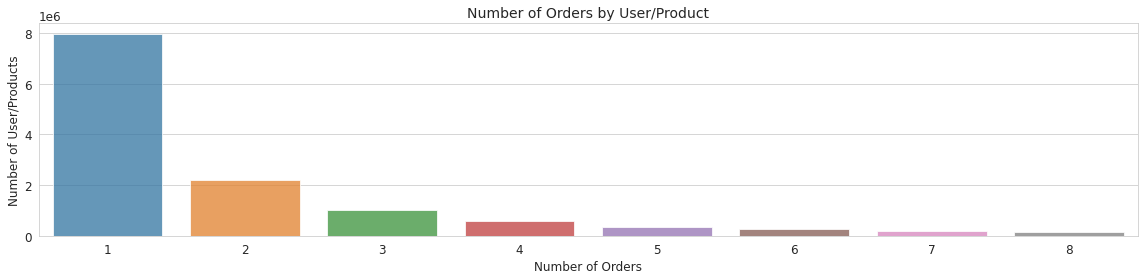

In [82]:
fig, axes = plt.subplots(1, 1, figsize=(16, 4))
to_plot = user_item_orders[user_item_orders <= user_item_orders.quantile(0.95)]
sns.countplot(to_plot, alpha=0.75, ax=axes)
axes.set(title="Number of Orders by User/Product", xlabel='Number of Orders', ylabel='Number of User/Products')

fig.tight_layout()
plt.show()

#### Most Popular Items

In [32]:
most_popular_items = cnt_user_item.to_frame('cnt_users').reset_index().sort_values('cnt_users', ascending=False).reset_index(drop=True)
most_popular_items['pct_users'] = most_popular_items['cnt_users'] / n_users
most_popular_items = pd.merge(most_popular_items, products_df, on='product_id', how='inner')
most_popular_items = most_popular_items[['cnt_users', 'pct_users', 'product_id', 'product_name', 'aisle_id', 'department_id']]
most_popular_items.head(10)

,cnt_users,pct_users,product_id,product_name,aisle_id,department_id
0,73956,0.359,24852,Banana,24,4
1,63537,0.308,13176,Bag of Organic Bananas,24,4
2,58838,0.285,21137,Organic Strawberries,24,4
3,55037,0.267,21903,Organic Baby Spinach,123,4
4,46402,0.225,47626,Large Lemon,24,4
5,44859,0.218,26209,Limes,24,4
6,43453,0.211,47209,Organic Hass Avocado,24,4
7,43149,0.209,16797,Strawberries,24,4
8,42771,0.207,47766,Organic Avocado,24,4
9,37138,0.180,39275,Organic Blueberries,123,4


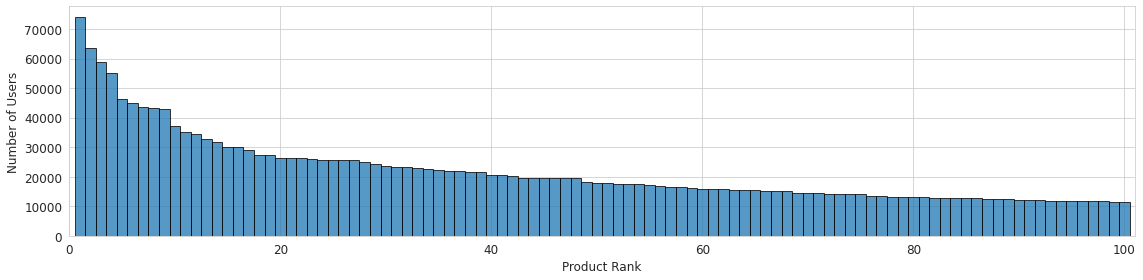

In [35]:
N = 100
to_plot = most_popular_items[:N]

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.bar(to_plot.index + 1, to_plot.cnt_users, width=1.0, linewidth=1, edgecolor='black', alpha=0.75)
ax.set(xlim=(0, N+1), xlabel='Product Rank', ylabel='Number of Users')
fig.tight_layout()
plt.show()

#### Print Matrix Shapes

In [36]:
print("users:", n_users)
print("items:", n_items)
print("interactions:", interactions.shape)
print("unique user/items pairs:", interactions[['user_id', 'product_id']].drop_duplicates().shape[0])

users: 206209
items: 49677
interactions: (32434489, 3)
unique user/items pairs: 13307953


#### Evaluate User/Item Interaction Sparsity

In [83]:
sparsity = 1 - (interactions[['user_id', 'product_id']].drop_duplicates().shape[0] / (n_users * n_items))
print("full interaction data sparsity: {}".format(round(100 * sparsity, 2)))

full interaction data sparsity: 99.87


### Subsample the Data for Initial Testing

#### Take a Random Subsample of Users

In [87]:
all_users = interactions.user_id.unique()
all_items = interactions.product_id.unique()

In [88]:
np.random.seed(1492)
s_users = np.random.choice(all_users, size=10000, replace=False)

#### Get All Interactions for Those Users

In [91]:
s_interactions = interactions[interactions.user_id.isin(s_users)].copy()
s_interactions.shape

(1615071, 3)

In [93]:
s_items = s_interactions.product_id.unique()
len(s_items)

35321

#### Re-Evaluate Cardinality/Sparsity on the Sample

In [96]:
n_s_users = len(s_users)
n_s_items = len(s_items)

print("sample users:", n_s_users)
print("sample items:", n_s_items)
print("sample interactions:", s_interactions.shape)

sample users: 10000
sample items: 35321
sample interactions: (1615071, 3)


In [97]:
s_sparsity = 1 - (s_interactions[['user_id', 'product_id']].drop_duplicates().shape[0] / (n_s_users * n_s_items))
print("sample interaction data sparsity: {}".format(round(100 * s_sparsity, 2)))

sample interaction data sparsity: 99.81


### Split the Data into Training/Validation Sets

#### Randomly Shuffle the Overall Interaction Data

In [98]:
shuffle_index = np.arange(len(s_interactions))
np.random.shuffle(shuffle_index)

s_interactions = s_interactions.iloc[shuffle_index]
s_interactions['random'] = np.random.random(size=len(s_interactions))
s_interactions.head()

,user_id,product_id,order_id,random
23537329,149525,10603,286068,0.552
9203424,58434,2078,1801316,0.730
17681539,111802,47209,1036583,0.123
10983869,69587,35221,1935694,0.915
14723363,93211,2539,1193650,0.212


#### Split Off 25% to Use for Validation

In [107]:
test_pct = 0.25
# GE: this trick is not necessary since s_interactions was subjected to a random permutation
train_mask = s_interactions['random'] <  (1 - test_pct)
valid_mask = s_interactions['random'] >= (1 - test_pct)
          
interactions_total = s_interactions[['user_id', 'product_id']]
interactions_total = interactions_total.iloc[shuffle_index]

interactions_train = s_interactions[train_mask].groupby(['user_id', 'product_id']).size().to_frame('orders').reset_index()
interactions_valid = s_interactions[valid_mask].groupby(['user_id', 'product_id']).size().to_frame('orders').reset_index()
#display(interactions_train.head())
# sample_weight_train = interactions_train['orders']
# sample_weight_valid = interactions_valid['orders']
sample_weight_train = np.log2(interactions_train['orders'] + 1)
sample_weight_valid = np.log2(interactions_valid['orders'] + 1)

interactions_train = interactions_train[['user_id', 'product_id']]
interactions_valid = interactions_valid[['user_id', 'product_id']]

In [114]:
train_users = np.sort(interactions_train.user_id.unique())
valid_users = np.sort(interactions_valid.user_id.unique())
cold_start_users = set(valid_users) - set(train_users)

train_items = np.sort(interactions_train.product_id.unique())
valid_items = np.sort(interactions_valid.product_id.unique())
cold_start_items = set(valid_items) - set(train_items)
# print(len(cold_start_users)) # 0
#print(len(cold_start_items)) # 1959

item_features_train = item_features[item_features.product_id.isin(train_items)]
item_features_valid = item_features[item_features.product_id.isin(valid_items)]

print("total shape: {}".format(interactions_total.shape))
print("train shape: {}".format(interactions_train.shape))
print("valid shape: {}".format(interactions_valid.shape))

print("\ntrain weights shape: {}".format(sample_weight_train.shape))
print("valid weights shape: {}".format(sample_weight_valid.shape))

print("\ntrain users: {}".format(len(train_users)))
print("valid users: {}".format(len(valid_users)))
print("cold-start users: {}".format(cold_start_users))

print("\ntrain items: {}".format(len(train_items)))
print("valid items: {}".format(len(valid_items)))
print("number of cold-start items: {}".format(len(cold_start_items)))

print("\ntrain item features: {}".format(item_features_train.shape))
print("valid item features: {}".format(item_features_valid.shape))

0
total shape: (1615071, 2)
train shape: (552348, 2)
valid shape: (262425, 2)

train weights shape: (552348,)
valid weights shape: (262425,)

train users: 10000
valid users: 9936
cold-start users: set()

train items: 33362
valid items: 25320
number of cold-start items: 1959

train item features: (33362, 135)
valid item features: (25320, 135)


### Test Out Core Package Functionality

#### Initialize the Model with Chosen Hyperparameters

In [116]:
model = RankFM(factors=50, loss='warp', max_samples=50, alpha=0.01, learning_rate=0.1, learning_schedule='invscaling')

#### Fit the Model on the Training Data and Profile Computational Performance

In [117]:
%%time
model.fit(interactions_train, sample_weight=sample_weight_train, epochs=30, verbose=True)


training epoch: 0
log likelihood: -283345.625

training epoch: 1
log likelihood: -277334.0

training epoch: 2
log likelihood: -268719.40625

training epoch: 3
log likelihood: -260925.4375

training epoch: 4
log likelihood: -252805.40625

training epoch: 5
log likelihood: -246793.53125

training epoch: 6
log likelihood: -242302.453125

training epoch: 7
log likelihood: -238361.53125

training epoch: 8
log likelihood: -235419.140625

training epoch: 9
log likelihood: -233545.734375

training epoch: 10
log likelihood: -231369.953125

training epoch: 11
log likelihood: -230310.546875

training epoch: 12
log likelihood: -228029.15625

training epoch: 13
log likelihood: -226963.5625

training epoch: 14
log likelihood: -226112.9375

training epoch: 15
log likelihood: -224978.765625

training epoch: 16
log likelihood: -223918.296875

training epoch: 17
log likelihood: -223227.671875

training epoch: 18
log likelihood: -222496.65625

training epoch: 19
log likelihood: -221807.9375

training ep

#### Generate Model Scores

In [50]:
%%time
scores = model.predict(interactions_valid, cold_start='nan') 

CPU times: user 361 ms, sys: 54 µs, total: 361 ms
Wall time: 360 ms


In [115]:
scores

NameError: name 'scores' is not defined

#### Generate TopN Recommendations

In [52]:
train_users = pd.Series(interactions_train.user_id.unique())
valid_users = pd.Series(interactions_valid.user_id.unique())
both_users = set(train_users) & set(valid_users)

len(train_users), len(valid_users), len(both_users)

(10000, 9936, 9936)

In [53]:
%%time
valid_recs = model.recommend(valid_users, n_items=10, filter_previous=False, cold_start='nan')

CPU times: user 31.7 s, sys: 0 ns, total: 31.7 s
Wall time: 31.7 s


In [54]:
print(valid_recs.shape)
valid_recs.head()

(9936, 10)


,0,1,2,3,4,5,6,7,8,9
33,33351,33129,33198,31808,24852,42240,10957,22882,17140,47626
61,48205,38400,9387,24852,39408,23909,7533,16797,27323,196
72,21137,24852,21903,13176,47209,40706,41950,22935,26209,42265
76,49235,13176,19057,36107,18523,27966,33754,6631,10957,33129
84,26209,47626,47209,28985,22935,47766,44632,24964,24852,21137


### Evaluate Model Performance on the Validation Data

#### Specify Number of Recommended Items

In [55]:
k = 10

#### Generate Pure-Popularity Baselines

In [56]:
most_popular = interactions_train.groupby('product_id')['user_id'].count().sort_values(ascending=False)[:k]
most_popular

product_id
24852    3333
13176    2904
21137    2565
21903    2511
47209    2003
47626    1983
26209    1950
47766    1841
16797    1839
39275    1590
Name: user_id, dtype: int64

In [57]:
test_user_items = interactions_valid.groupby('user_id')['product_id'].apply(set).to_dict()
test_user_items = {key: val for key, val in test_user_items.items() if key in set(train_users)}

base_hrt = np.mean([int(len(set(most_popular.index) & set(val)) > 0)                       for key, val in test_user_items.items()])
base_pre = np.mean([len(set(most_popular.index) & set(val)) / len(set(most_popular.index)) for key, val in test_user_items.items()])
base_rec = np.mean([len(set(most_popular.index) & set(val)) / len(set(val))                for key, val in test_user_items.items()])

In [58]:
print("number of test users: {}".format(len(test_user_items)))
print("baseline hit rate: {:.3f}".format(base_hrt))
print("baseline precision: {:.3f}".format(base_pre))
print("baseline recall: {:.3f}".format(base_rec))

number of test users: 9936
baseline hit rate: 0.602
baseline precision: 0.134
baseline recall: 0.058


#### Generate Model Performance Validation Metrics

In [61]:
%%time
model_hrt = hit_rate(model, interactions_valid, k=k)
model_rnk = reciprocal_rank(model, interactions_valid, k=k)
model_pre = precision(model, interactions_valid, k=k)
model_rec = recall(model, interactions_valid, k=k)

CPU times: user 2min 11s, sys: 27.5 ms, total: 2min 11s
Wall time: 2min 11s


In [63]:
print("model hit rate: {}".format(round(model_hrt, 3)))
print("model reciprocal rank: {}".format(round(model_rnk, 3)))
print("model precision: {}".format(round(model_pre, 3)))
print("model recall: {}".format(round(model_rec, 3)))

model hit rate: 0.785
model reciprocal rank: 0.478
model precision: 0.232
model recall: 0.122


#### Assess the Diversity of Recommendations

In [64]:
model_diversity = diversity(model, interactions_valid, k=k).rename({'item_id': 'product_id'}, axis=1)
model_diversity = pd.merge(model_diversity, products_df, on='product_id', how='inner')
model_diversity = model_diversity[['cnt_users', 'pct_users', 'product_id', 'product_name', 'aisle_id', 'department_id']]
model_diversity.head(20)

,cnt_users,pct_users,product_id,product_name,aisle_id,department_id
0,5674,0.571,24852,Banana,24,4
1,4976,0.501,13176,Bag of Organic Bananas,24,4
2,4859,0.489,21137,Organic Strawberries,24,4
3,4470,0.450,21903,Organic Baby Spinach,123,4
4,3164,0.318,47209,Organic Hass Avocado,24,4
5,3055,0.307,26209,Limes,24,4
6,2269,0.228,22935,Organic Yellow Onion,83,4
7,2173,0.219,47626,Large Lemon,24,4
8,2132,0.215,27966,Organic Raspberries,123,4
9,2127,0.214,47766,Organic Avocado,24,4


In [65]:
coverage = np.mean(model_diversity['cnt_users'] > 0)
round(coverage, 3)

0.154

In [66]:
nonzero = model_diversity[model_diversity.cnt_users > 0]
entropy = -np.sum(nonzero['pct_users'] * np.log2(nonzero['pct_users']))
round(entropy, 2)

45.63

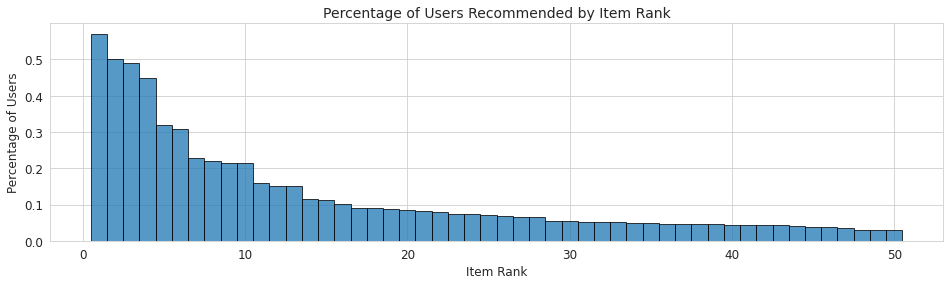

In [67]:
fig, axes = plt.subplots(1, 1, figsize=[16, 4])
N = 50

topN = model_diversity.iloc[:N, :]
axes.bar(topN.index.values + 1, topN.pct_users, width=1, edgecolor='black', alpha=0.75)
axes.set(xlabel='Item Rank', ylabel='Percentage of Users', title='Percentage of Users Recommended by Item Rank')
plt.show()

#### Get Similar Items for a Few Items

In [68]:
random_user = np.random.choice(valid_users)
print("random user: {}".format(random_user))

random user: 143264


In [69]:
random_user_recs = valid_recs.loc[random_user]
random_user_recs = products_df[products_df.product_id.isin(random_user_recs)].set_index('product_id').loc[random_user_recs]
random_user_recs

,product_name,aisle_id,department_id
product_id,,,
27360,Boneless Skinless Chicken Breast Fillets,49,12
47977,Grapefruit Sparkling Water,115,7
24097,Rotini Pasta,131,9
48205,Spinach,123,4
19604,Medium Scarlet Raspberries,24,4
48527,Avocado,24,4
16414,Finely Shredded Parmesan Cheese,21,16
43205,Low Sodium Black Beans,59,15
31573,Whole Grain Brown Ready Rice,4,9


#### Look at Similar Products for a Few of the Random User's Recommended Products

In [70]:
most_similar_items = model.similar_items(48370)
most_similar_items = products_df.set_index('product_id').loc[most_similar_items]
most_similar_items

,product_name,aisle_id,department_id
product_id,,,
14999,Grade A Large Brown Eggs,86,16
45698,One Ply Choose A Size Big Roll Paper Towel Rolls,54,17
4136,Living Herbs Potted Living Basil,16,4
15945,Freshly Shredded Parmesan Cheese,21,16
41771,Fresh European Style Baby Spinach,123,4
21144,Grab & Go Classic Hummus With Pretzel Crisps,107,19
1447,Organic Baby Lettuces,123,4
3265,Mini Seedless Watermelon Pack,32,4
24750,Organic Whole Fryer Chicken,35,12


### Asess Model Performance on Novel Item Recommendations

#### Save an Array of the Most Popular Items in the Training Data

In [71]:
most_popular = interactions_train.groupby('product_id')['user_id'].count().sort_values(ascending=False)
print(len(most_popular))
most_popular.head(10)

33362


product_id
24852    3333
13176    2904
21137    2565
21903    2511
47209    2003
47626    1983
26209    1950
47766    1841
16797    1839
39275    1590
Name: user_id, dtype: int64

In [72]:
most_popular = pd.Series(most_popular.index.values)
most_popular[:10]

0    24852
1    13176
2    21137
3    21903
4    47209
5    47626
6    26209
7    47766
8    16797
9    39275
dtype: int64

#### Save the TopK Most Popular Items Not Yet Previously Purchased for Each Customer

In [73]:
train_user_items = interactions_train.groupby('user_id')['product_id'].apply(set).to_dict()
train_user_items = {key: val for key, val in test_user_items.items() if key in set(valid_users)}
most_popular_new = {user: most_popular[~most_popular.isin(train_user_items[user])][:k] for user in train_user_items.keys()}
len(most_popular_new)

9936

In [74]:
list(most_popular_new.keys())[:10]

[33, 61, 72, 76, 84, 109, 140, 146, 173, 190]

In [75]:
most_popular_new[140]

0     24852
5     47626
7     47766
8     16797
9     39275
12    45007
14    49683
15     4605
18     4920
19    42265
dtype: int64

#### Calculate the Pure-Popularity Baseline Metrics on Previously Unpurchased Items

In [76]:
base_new_hrt = np.mean([int(len(set(most_popular_new[user]) & set(test_user_items[user])) > 0)                           for user in test_user_items.keys()])
base_new_pre = np.mean([len(set(most_popular_new[user]) & set(test_user_items[user])) / len(set(most_popular_new[user])) for user in test_user_items.keys()])
base_new_rec = np.mean([len(set(most_popular_new[user]) & set(test_user_items[user])) / len(set(test_user_items[user]))  for user in test_user_items.keys()])

In [77]:
print("number of test users: {}".format(len(test_user_items)))
print("baseline new hit rate: {:.3f}".format(base_new_hrt))
print("baseline new precision: {:.3f}".format(base_new_pre))
print("baseline new recall: {:.3f}".format(base_new_rec))

number of test users: 9936
baseline new hit rate: 0.000
baseline new precision: 0.000
baseline new recall: 0.000


#### Calculate Model Performance Excluding Training Items

In [78]:
%%time
model_hrt_new = hit_rate(model, interactions_valid, k=k, filter_previous=True)
model_pre_new = precision(model, interactions_valid, k=k, filter_previous=True)
model_rec_new = recall(model, interactions_valid, k=k, filter_previous=True)

CPU times: user 1min 38s, sys: 7.85 ms, total: 1min 38s
Wall time: 1min 38s


In [79]:
print("model new hit rate: {}".format(round(model_hrt_new, 3)))
print("model new precision: {}".format(round(model_pre_new, 3)))
print("model new recall: {}".format(round(model_rec_new, 3)))

model new hit rate: 0.333
model new precision: 0.043
model new recall: 0.026


### Compare **RankFM** Performance to the **LightFM** Package

In [81]:
from lightfm.data import Dataset
from lightfm import LightFM, evaluation

#### Create Required Data Structures

In [82]:
all_users = interactions_total.user_id.unique()
all_items = interactions_total.product_id.unique()
print(len(all_users), len(all_items))

lfm_dataset = Dataset()
lfm_dataset.fit(users=all_users, items=all_items)

lfm_interactions, lfm_weights = lfm_dataset.build_interactions(zip(interactions_train['user_id'], interactions_train['product_id'], sample_weight_train))
lfm_interactions, lfm_weights

10000 35321


(<10000x35321 sparse matrix of type '<class 'numpy.int32'>'
 	with 552348 stored elements in COOrdinate format>,
 <10000x35321 sparse matrix of type '<class 'numpy.float32'>'
 	with 552348 stored elements in COOrdinate format>)

#### Fit the Model

In [83]:
lfm_model = LightFM(no_components=50, loss='warp', max_sampled=50)
lfm_model

In [84]:
%%time
lfm_model.fit(lfm_interactions, epochs=20, verbose=True)

Epoch: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]

CPU times: user 18.5 s, sys: 4.05 ms, total: 18.5 s
Wall time: 18.5 s


In [85]:
print(all_users.shape, all_items.shape)
print(valid_users.shape, valid_items.shape)

(10000,) (35321,)
(9936,) (25320,)


#### Evaluate LightFM's Performance on Hold-Out Data

In [86]:
lfm_test_interactions, lfm_test_weights = lfm_dataset.build_interactions(zip(interactions_valid['user_id'], interactions_valid['product_id']))
lfm_test_interactions

<10000x35321 sparse matrix of type '<class 'numpy.int32'>'
	with 262425 stored elements in COOrdinate format>

In [87]:
%%time
lfm_rnk = evaluation.reciprocal_rank(lfm_model, lfm_test_interactions).mean()
lfm_pre = evaluation.precision_at_k(lfm_model, lfm_test_interactions, k=k).mean()
lfm_rec = evaluation.recall_at_k(lfm_model, lfm_test_interactions, k=k).mean()

CPU times: user 46.9 s, sys: 0 ns, total: 46.9 s
Wall time: 46.9 s


In [88]:
print("reciprocal_rank: {:.3f}".format(lfm_rnk))
print("precision: {:.3f}".format(lfm_pre))
print("recall: {:.3f}".format(lfm_rec))

reciprocal_rank: 0.408
precision: 0.177
recall: 0.091
